![cool map](./../figures/python_logo_map.png)

![slide 1](./../figures/voronoi_slide_1.png)

# Ohh, How do I make that cool looking map?!

- You must be thinking, "damn that map must be tricky to make".
- But nah, its pretty easy actually.
  - And it makes for an engaging tutorial.
- Lets walk through it 🚶‍♀️🗺️

In [1]:
# the usual suspects
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# geopandas for geospatial muning and visuals
import geopandas as gpd
# library for accessing map raster tiles
import contextily as ctx
# shapely objects and tools
from shapely.geometry import Polygon
from shapely.affinity import scale
# svg stuff for the python logo
from svgpath2mpl import parse_path
from xml.dom import minidom

# Getting our extents from an existing file

- Fiddingly manually with your extents on maps is hard and not a great idea.
- So we will get them from a polygon I drew specifically to for this map.
- It is in a `geopackage`.
- Why use a geopackage? A modern GIS file standard...
- PLEASE stop using shapefiles. I beg of you! 🙏

In [2]:
# read in file using geopandas
extents = gpd.read_file("./../data/extents.gpkg")
extents # show the table

Name                                           geometry
0  City  POLYGON ((115.81190 -31.98681, 115.81190 -31.9...

We can plot this so we know we have what we expect:

- we also use `contextily` to pull in the openstreetmap background.
- make sure you call `add_basemap` *after* you draw your plot otherwise it will not plot at the limits you expect.

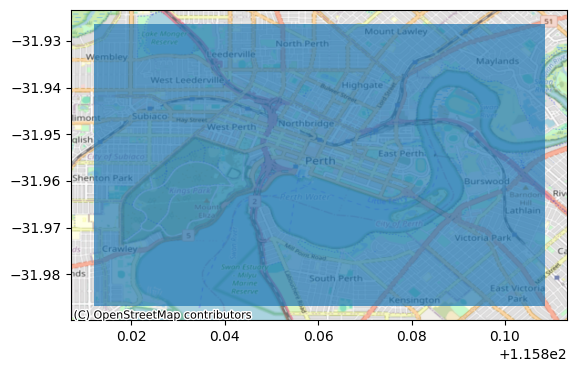

In [3]:
# plot it so we know what we're looking at
fig, ax = plt.subplots()
extents.plot(ax=ax, alpha=0.7)
# add a basemap using contextily to give us some context
# it is helpful to call this after plotting the geopandas object
# as otherwise the basemap will download tiles it doesn't need.
ctx.add_basemap(ax
    ,crs=extents.crs.to_string()
    ,source=ctx.providers.OpenStreetMap.Mapnik)

In [4]:
extents.crs # coordinate reference system

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can get the boundaries from the single polygon entry in `extents`:

- Be careful! We have latitudes and longitdues here!

In [5]:
boundaries = extents.geometry.bounds
xlims = (boundaries["minx"].values[0], boundaries["maxx"].values[0])
ylims = (boundaries["miny"].values[0], boundaries["maxy"].values[0])
print(f"X limits: {xlims[0]:.3f}, {xlims[1]:.3f}\n"
      f"Y limits: {ylims[0]:.3f}, {ylims[1]:.3f}")

X limits: 115.812, 115.908
Y limits: -31.987, -31.926


Often we will want to use a different coordinate system, such as `GDA2020 UTM Zone 50`:

- `GDA2020 UTM Zone 50` uses a "Universal Transverse Mercator (UTM)" method.
- And as a result these coordinates are now in **meters**.

In [6]:
extents_straya = extents.to_crs("EPSG:7850")
boundaries_straya = extents_straya.geometry.bounds
xlims_straya = (boundaries_straya["minx"].values[0], boundaries_straya["maxx"].values[0])
ylims_straya = (boundaries_straya["miny"].values[0], boundaries_straya["maxy"].values[0])
print(f"X limits: {xlims_straya[0]:.3f}, {xlims_straya[1]:.3f}\n"
      f"Y limits: {ylims_straya[0]:.3f}, {ylims_straya[1]:.3f}")

X limits: 387684.633, 396884.235
Y limits: 6460410.220, 6467201.731


We will continue using WGS84 for now. But will come back to projections later 🫣

## SVG to Geopandas (via shapely)

- We open up the SVG file using `xml`.
- We parse the objects we want using `svgpath2mpl`.
- The `path` objects we extract from the SVG have a little gotcha:
  - Some of them have multiple paths inside them! Hence the extra `for loop` here.
- We use the `shapely.Polygon` type to turn out paths into GIS objects...
- but they still need some work:
  - Our paths have coordinates that dont mean anything on a map.
  - So we scale them by a `scale_factor` to make the coordinates make sense.
  - And center them over Kings Park using `desired_origin` instead of at (0,0) <- this is null island btw!
  - we use `shapely.affinity.scale()` to do this.

In [7]:
scale_factor = 2.9e-4
desired_origin = (115.815,-31.983) # WGS coordinates for somewhere on the UWA campus
# Parse the SVG file
doc = minidom.parse('./../data/Python-logo-notext.svg')  
paths = doc.getElementsByTagName('path')
# Convert paths to polygons and add to list
all_polygons = []
for path in paths:
    d = path.getAttribute('d')
    mpl_path = parse_path(d)
    poly_paths = mpl_path.to_polygons()
    for poly_path in poly_paths:
        # conver to shapely.Polygon
        polygon = Polygon(poly_path)
        scaled_polygon = scale(polygon
                              ,xfact=-scale_factor
                              ,yfact=scale_factor
                              ,origin=desired_origin)
        all_polygons.append(scaled_polygon)

# show our list of polygons to the attendees (hi!):
all_polygons

[<POLYGON ((115.833 -31.974, 115.834 -31.974, 115.836 -31.974, 115.836 -31.97...>,
 <POLYGON ((115.837 -31.971, 115.837 -31.971, 115.836 -31.971, 115.836 -31.97...>,
 <POLYGON ((115.824 -31.965, 115.824 -31.962, 115.824 -31.961, 115.824 -31.96...>,
 <POLYGON ((115.828 -31.947, 115.828 -31.947, 115.827 -31.946, 115.827 -31.94...>]

Shapely lets us view what these polygons look like by calling them in a notebook - neat!

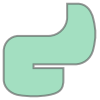

In [8]:
first_polygon_example = all_polygons[0]
first_polygon_example

If you want to access the polygon's coordinates you can do this:

In [9]:
first_polygon_example.exterior.coords.xy

(array('d', [115.83265990234999, 115.83364936607374, 115.83551875530124, 115.83637552734999, 115.83697143883663, 115.83796515053758, 115.83874323057204, 115.83933023656253, 115.8397507261316, 115.84002925690177, 115.84024467070124, 115.84026333985, 115.84026333985, 115.83248771484999, 115.83248771484999, 115.84026333985, 115.84318146484999, 115.8436029840568, 115.84441774403416, 115.8451871922263, 115.84589868678698, 115.84653958586985, 115.84709724762864, 115.84755903021704, 115.84791229178877, 115.848038964792, 115.84828536705184, 115.84856051182912, 115.84856644931268, 115.84829427327719, 115.848038964792, 115.84780771855455, 115.84729395109488, 115.8468617908906, 115.84635062199095, 115.84575842179851, 115.84508316771587, 115.84432283714564, 115.84390646485, 115.84123302734999, 115.84123302734999, 115.84121567913311, 115.84101807210452, 115.84064400119514, 115.8401146095528, 115.8394510403253, 115.83867443666045, 115.83780594170608, 115.83686669861, 115.83637552734999, 115.82860896

Now we put the polygons into a geopandas df:

- GeoDataFrames can be generated from a supplied list of geometries.
- We make sure to tell it that our projection system is WGS84.
  - that is the degrees of latitude and longitude we often use.
  - we do so using the handy EPSG catalog number system, for WGS84: `EPSG:4326`.
- We also assign some colours for plotting. I know the order of the shapes from trial and error.

In [10]:
# Create a GeoDataFrame from the polygons
gdf = gpd.GeoDataFrame(geometry=all_polygons, crs="EPSG:4326")
# we can add a column just like in pandas:
gdf["order"] = list(range(4))
gdf

geometry  order
0  POLYGON ((115.83266 -31.97372, 115.83365 -31.9...      0
1  POLYGON ((115.83686 -31.97134, 115.83657 -31.9...      1
2  POLYGON ((115.82375 -31.96541, 115.82375 -31.9...      2
3  POLYGON ((115.82812 -31.94666, 115.82782 -31.9...      3

And we can now plot out the Python Logo on a map!

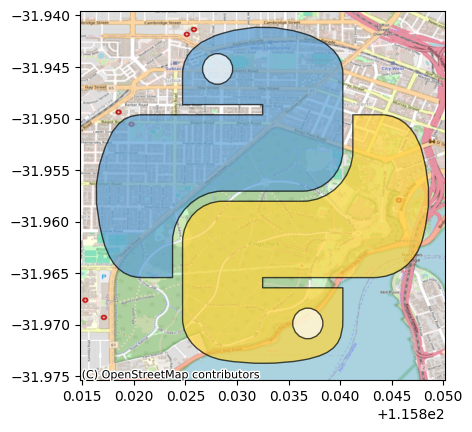

In [11]:
# plot it so we know what we're looking at
fig, ax = plt.subplots()
# custom cmap so we plot the right colours
colour_sequence = ["#ffd43bff", "white", "#5a9fd4ff", "white"]
cmap = matplotlib.colors.ListedColormap(colour_sequence)
gdf.plot(ax=ax, alpha=0.7, edgecolor="black", cmap=cmap)
ctx.add_basemap(ax, crs=extents.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# 🌿 A nice and leafy background for our map 🌿

Next, we need some neat geospatial data to put on our map:
- There is *lots* of map data out there!
- Because we are in Perth, lets use something local:
  - [Urban Forest Mesh Blocks 2020](https://catalogue.data.wa.gov.au/dataset/urban-forest-mesh-blocks-2020-dplh-096)
  - Which comes from data WA, a beautiful place full of delicious data 🙏🥳
- This dataset is unweildy in python, so I clipped it before importing.
- You can do this with the `bbox` argument in `geopandas.read_file()`. But it is still slow.

totalpcent  grasspc                                           geometry
0        10.6      1.5  MULTIPOLYGON (((115.83323 -31.93470, 115.83307...
1         7.6      0.7  MULTIPOLYGON (((115.83312 -31.93617, 115.83323...
2         9.3      4.2  MULTIPOLYGON (((115.83336 -31.92641, 115.83336...
3        20.0     62.5  MULTIPOLYGON (((115.83577 -31.93101, 115.83466...
4        20.2      4.6  MULTIPOLYGON (((115.83561 -31.93464, 115.83540...

<Axes: >

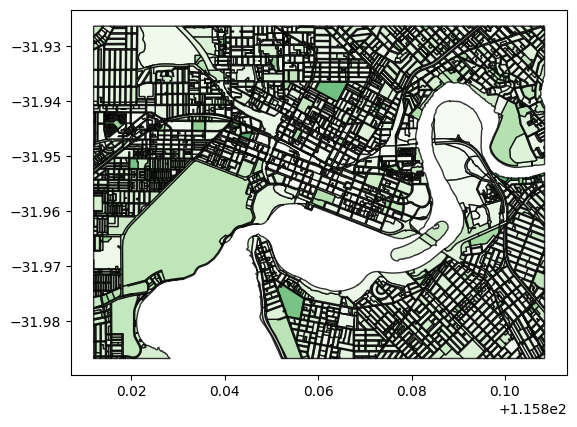

In [12]:
urban_forest = gpd.read_file("./../data/urban_forest_mesh_2020_clipped_city.gpkg")
display(urban_forest[['totalpcent', 'grasspc', 'geometry']].head())
urban_forest.plot(column="totalpcent", cmap="Greens", edgecolor="black", alpha=0.8)


# Bring it all together

![coming together me](./../data/coming_together_meme.jpg)

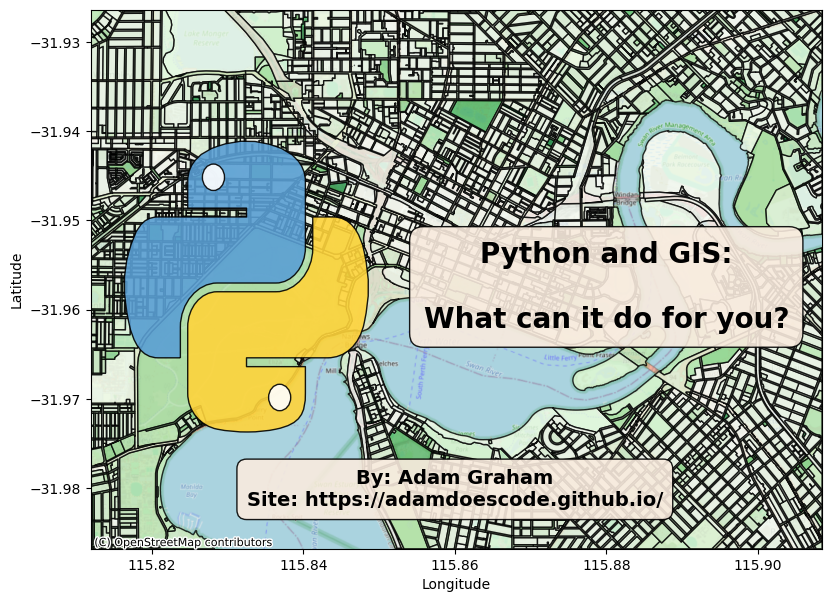

In [13]:
fig, ax = plt.subplots(figsize=(18,7))

# draw our plot of the python logo
# colours for custom colour map
colour_sequence = ["#ffd43bff", "white", "#5a9fd4ff", "white"]
cmap = matplotlib.colors.ListedColormap(colour_sequence)
gdf.plot(ax=ax, alpha=0.9, edgecolor="black", cmap=cmap, zorder=2)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# make x-axis not show scientific notation
# (this is a co-pilot prompt because I don't bother 
#  remembering random matlplotlib crap 🙄)
ax.get_xaxis().get_major_formatter().set_useOffset(False)

# add the basemap
# first set limits so we don't waste bandwidth downloading extra tiles
ax.set_xlim(xlims)
ax.set_ylim(ylims)
geo_data_frame_crs = gdf.crs.to_string()
ctx.add_basemap(ax, crs=geo_data_frame_crs
                ,zoom=14 #make this smaller to go faster, looks nicer at this than default
                ,source=ctx.providers.OpenStreetMap.Mapnik)

# add the urban forest data
urban_forest.plot(column="totalpcent", cmap="Greens", edgecolor="black"
                  ,alpha=0.8, ax=ax, zorder=1)

# finally, we add the text
title_text = "Python and GIS:\n\nWhat can it do for you?"
subtitle_text = """By: Adam Graham
Repo: https://github.com/adamdoescode/pythonwa_gis_and_python"""
shared_text_args = dict(color='black', ha='center', fontweight='bold'
                        ,bbox=dict(facecolor='#f9ebde', alpha=0.9
                        ,edgecolor='black', boxstyle='round,pad=0.5'))
ax.text(115.88,-31.962, title_text, fontsize=20, **shared_text_args)
ax.text(115.86,-31.982, subtitle_text, fontsize=14, **shared_text_args)

plt.savefig("./../figures/python_logo_map.png", bbox_inches='tight', dpi=200)

# Gratuitous Voronois

- Voronoi polygons are a way of dividing an area between a set of points.
- Useful for:
  - Find what areas are closest to each point
  - Make pretty maps
  - Probably some other things, idk.
- We get our voronoi functionality from `geoplot`

In [14]:
import geoplot

## Centroids from polygons

First we need to make some points...

/tmp/ipykernel_8859/2420162587.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  urban_forest_centroids = urban_forest.geometry.centroid


(-31.986806240346443, -31.926406689649802)

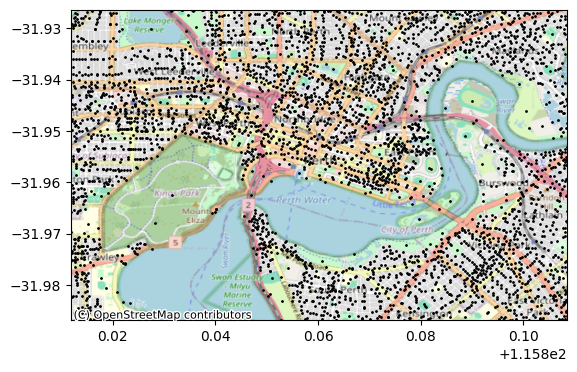

In [15]:
# get centroids
urban_forest_centroids = urban_forest.geometry.centroid
urban_forest_centroids = gpd.GeoDataFrame(
                            geometry=urban_forest_centroids
                            ,crs=urban_forest.crs) # type: ignore
fig, ax = plt.subplots()
urban_forest_centroids.plot(ax=ax, color="black", markersize=1)
ctx.add_basemap(ax, crs=urban_forest.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

/home/sp/miniconda3/lib/python3.11/site-packages/geoplot/geoplot.py:56: UserWarning: The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.
  warnings.warn(
/home/sp/miniconda3/lib/python3.11/site-packages/pandas/core/frame.py:5239: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data[k] = com.apply_if_callable(v, data)


(-31.986806240346443, -31.926406689649802)

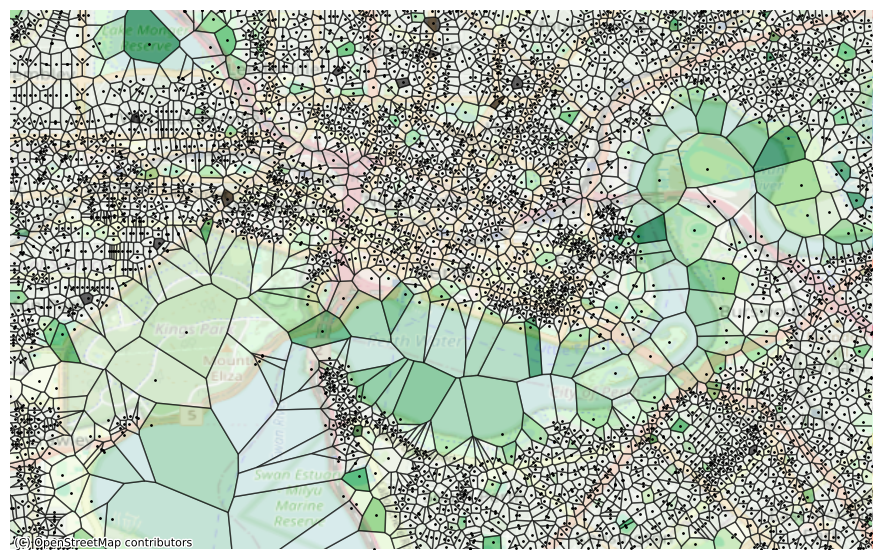

In [16]:
urban_forest_centroids["grasspc"] = urban_forest["grasspc"]

fig,ax = plt.subplots(figsize=(18,7))
geoplot.voronoi(
    urban_forest_centroids
    ,hue="grasspc"
    ,ax=ax
    ,cmap="Greens"
    ,alpha=0.6)

urban_forest_centroids.plot(ax=ax, color="black", markersize=1)
ctx.add_basemap(ax, crs=urban_forest.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

And the version used for slides:

/home/sp/miniconda3/lib/python3.11/site-packages/geoplot/geoplot.py:56: UserWarning: The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.
  warnings.warn(
/home/sp/miniconda3/lib/python3.11/site-packages/pandas/core/frame.py:5239: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data[k] = com.apply_if_callable(v, data)


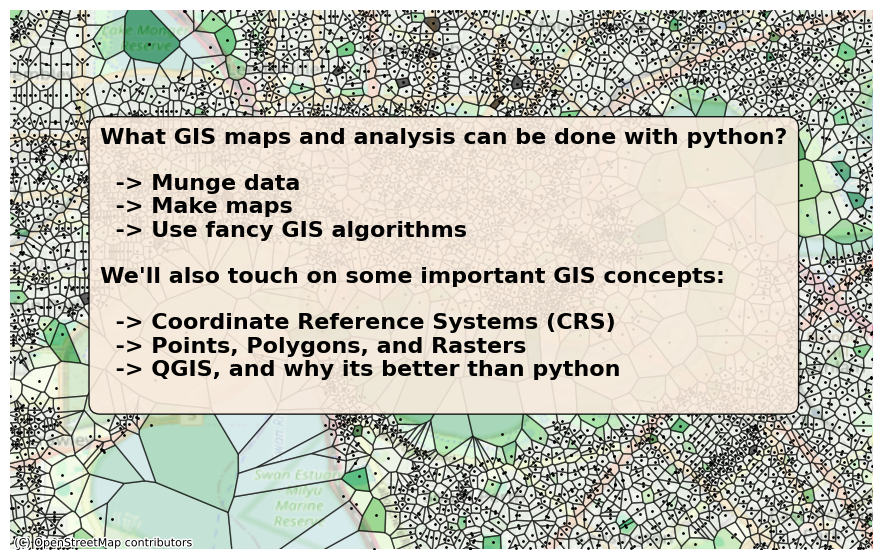

In [17]:
voronoi_figsize=(18,7)
fig, ax = plt.subplots(figsize=voronoi_figsize)
ax = geoplot.voronoi(
    urban_forest_centroids
    ,hue="grasspc"
    ,ax=ax
    ,cmap="Greens"
    ,alpha=0.6)

urban_forest_centroids.plot(ax=ax, color="black", markersize=1)
ctx.add_basemap(ax, crs=urban_forest.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

slide_text = (
"""What GIS maps and analysis can be done with python?

  -> Munge data
  -> Make maps
  -> Use fancy GIS algorithms

We'll also touch on some important GIS concepts:

  -> Coordinate Reference Systems (CRS)
  -> Points, Polygons, and Rasters
  -> QGIS, and why its better than python
""")
shared_text_args = dict(color='black', ha='left', fontweight='bold'
                        ,bbox=dict(facecolor='#f9ebde', alpha=0.9
                        ,edgecolor='black', boxstyle='round,pad=0.5'))
ax.text(115.822,-31.97, slide_text, fontsize=16, **shared_text_args)
plt.savefig("./../figures/voronoi_slide_1.png", bbox_inches='tight', dpi=200)